## Assignment 1: CSC-478 Programming Machine Learning Applications
**Eric Newnam**<br>
Winter 2018

- Concentrate on two columns only: the **timestamp** and the **price in dollars (eth_etherprice)**. 
- Do not shuffle the dataset but break it into two halfs. 
- Treat the first half as training and the second half as testing data. 
- For every trading day compute the log return of the previous 10 days closing price. 
- Treat the log return of the prevous 10 days as distinct features and try predict whether the log return of the next day will be positive or negative. 

In your notebook run the prediciton using KNN and the LogisticRegression algorithms. Show the confusion matrix and compute the F1 parameter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
eth_df = pd.read_csv('ethereum_dataset.csv')
eth_df.head()

,Date(UTC),UnixTimeStamp,eth_etherprice,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,eth_ethersupply,eth_ens_register
0,7/30/2015,1438214400,0.0,8893,9205,7.204931e+07,0.0,23.7569,0.121,6912,1299,644,4.46,0,0,0,39316.09375,NaN
1,7/31/2015,1438300800,0.0,0,9361,7.208550e+07,0.0,48.1584,0.603,6863,511,582,12.58,0,0,0,36191.71875,NaN
2,8/1/2015,1438387200,0.0,0,9476,7.211320e+07,0.0,55.2709,0.887,5293,334,575,16.34,0,0,0,27705.93750,NaN
3,8/2/2015,1438473600,0.0,0,9563,7.214143e+07,0.0,64.1779,1.020,5358,394,581,16.12,0,0,0,28223.43750,NaN
4,8/3/2015,1438560000,0.0,0,9639,7.216940e+07,0.0,69.8559,1.126,5280,443,587,16.37,0,0,0,27976.71875,NaN


In [3]:
eth_df.shape

(832, 18)

### Extract the 2 features we are interested in:
- UnixTimeStamp
- eth_etherprice

In [4]:
etherprice_df = eth_df.loc[:, ['UnixTimeStamp', 'eth_etherprice']]
etherprice_df.head()

,UnixTimeStamp,eth_etherprice
0,1438214400,0.0
1,1438300800,0.0
2,1438387200,0.0
3,1438473600,0.0
4,1438560000,0.0


### Split the dataset into 2 halves:
- Treat the first half as training and the second half as testing data.

In [5]:
etherprice_df.shape

(832, 2)

- 50% of our dataset is 416 observations:

In [6]:
X = etherprice_df[:416]
X_t = etherprice_df[416:]
print(X.shape)
print(X_t.shape)

(416, 2)
(416, 2)


### For every trading day compute the log return of the previous 10 days closing price:
- You always compute the log return relative to the previous day closing. So if Price[t] is the price on day t, R[t] = log(Price[t]/Price[t-1]) and the features for day t are: R[t-9], R[t-8],… R[t] and you are trying to predict the sign of R[t+1].

In [7]:
# create a copy of the X dataframe:
X_train = X.copy(deep=True)
X_test = X_t.copy(deep=True)

In [8]:
#X = X[X['eth_etherprice'] > 0.0]

In [9]:
for i in range(11):
    X_train['lgrt_minus'+str(i)] = (np.log(X['eth_etherprice'].shift(i)) 
                                  - np.log(X['eth_etherprice'].shift(i+1)))
    X_test['lgrt_minus'+str(i)] = (np.log(X_t['eth_etherprice'].shift(i)) 
                                 - np.log(X_t['eth_etherprice'].shift(i+1)))

/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


### Prepare the data and create the labels:
- run the prediciton using **KNN** and the **LogisticRegression** algorithms.
- We will first create the observed y, to train and test against:

In [10]:
# create the observed ground truth result for the training set:
X_train['price_increase'] = (X_train['eth_etherprice'].shift(-1) > X_train['eth_etherprice'])

# also create the result for the testing set:
X_test['price_increase'] = (X_test['eth_etherprice'].shift(-1) > X_test['eth_etherprice'])

In [11]:
# check the boolean results:
X_train['price_increase'] = X_train['price_increase'].astype('int')
X_test['price_increase'] = X_test['price_increase'].astype('int')

X_train.loc[0:15, ['eth_etherprice', 'price_increase']]

,eth_etherprice,price_increase
0,0.00,0
1,0.00,0
2,0.00,0
3,0.00,0
4,0.00,0
5,0.00,0
6,0.00,0
7,0.00,1
8,3.00,0
9,1.20,0


- Drop the NaN observations:
- Drop the infinite values:

In [12]:
# drop the NaN values before we train the classifier:
X_train = X_train.dropna(axis=0, how='any')
X_test = X_test.dropna(axis=0, how='any')

# drop 'inf' observations 18, 19, 20, 21, 22:
X_train = X_train.drop([18, 19, 20, 21, 22])

# create Y_train and Y_test:
Y_train = X_train['price_increase']
Y_test = X_test['price_increase']
X_train = X_train.drop('price_increase', axis=1)
X_test = X_test.drop('price_increase', axis=1)

- Print the head as a sanity test:

In [13]:
X_train.head()

,UnixTimeStamp,eth_etherprice,lgrt_minus0,lgrt_minus1,lgrt_minus2,lgrt_minus3,lgrt_minus4,lgrt_minus5,lgrt_minus6,lgrt_minus7,lgrt_minus8,lgrt_minus9,lgrt_minus10
23,1440201600,1.40,-0.028171,-0.054067,0.203599,-0.092373,-0.007326,0.052446,-0.319851,0.000000,-0.049056,0.376630,0.264693
24,1440288000,1.35,-0.036368,-0.028171,-0.054067,0.203599,-0.092373,-0.007326,0.052446,-0.319851,0.000000,-0.049056,0.376630
25,1440374400,1.24,-0.084993,-0.036368,-0.028171,-0.054067,0.203599,-0.092373,-0.007326,0.052446,-0.319851,0.000000,-0.049056
26,1440460800,1.27,0.023906,-0.084993,-0.036368,-0.028171,-0.054067,0.203599,-0.092373,-0.007326,0.052446,-0.319851,0.000000
27,1440547200,1.18,-0.073502,0.023906,-0.084993,-0.036368,-0.028171,-0.054067,0.203599,-0.092373,-0.007326,0.052446,-0.319851


In [14]:
X_test.head()

,UnixTimeStamp,eth_etherprice,lgrt_minus0,lgrt_minus1,lgrt_minus2,lgrt_minus3,lgrt_minus4,lgrt_minus5,lgrt_minus6,lgrt_minus7,lgrt_minus8,lgrt_minus9,lgrt_minus10
427,1475020800,13.30,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352,0.129657,0.042660
428,1475193600,13.24,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352,0.129657
429,1475280000,13.21,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352
430,1475366400,13.23,0.001513,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479
431,1475452800,13.45,0.016492,0.001513,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890


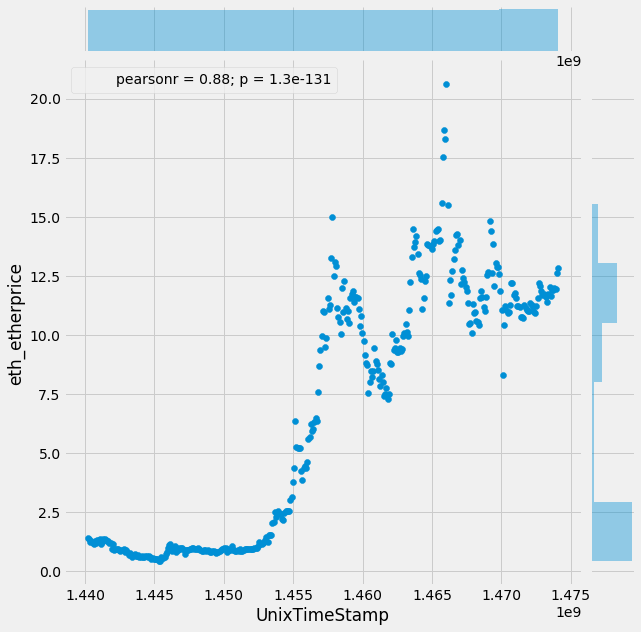

In [15]:
plt.style.use('fivethirtyeight')
sns.jointplot('UnixTimeStamp', 'eth_etherprice', data=X_train, kind='scatter', size=9, ratio=10);

## Try predict whether the log return of the next day will be positive or negative:
- First we'll use the KNN algorithm:
- We will try different values of K and choose the best performing:

In [16]:
feat = ['lgrt_minus1', 
        'lgrt_minus2', 
        'lgrt_minus3', 
        'lgrt_minus4', 
        'lgrt_minus5', 
        'lgrt_minus6', 
        'lgrt_minus7', 
        'lgrt_minus8', 
        'lgrt_minus9', 
        'lgrt_minus10']
X_train_reduced = X_train[feat]
X_test_reduced = X_test[feat]

### Run *K-Nearest Neighbors* with a range of k = 3 to 50:

In [17]:
# cycle through 3 to 50 neighbors and graph results:
accuracy_list = []
for k in range(3, 51):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced, Y_train)
    y_hat = knn.predict(X_test_reduced)
    accuracy_list.append(accuracy_score(Y_test, y_hat))

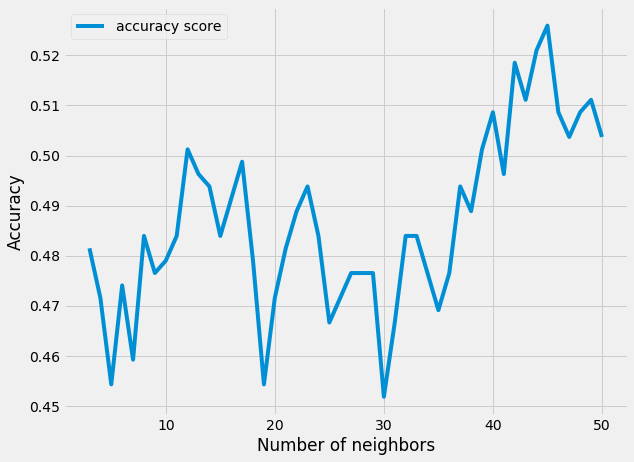

In [18]:
plt.figure(figsize=(9, 7))
plt.style.use('fivethirtyeight')
x_units = list(range(3, 51))
plt.plot(x_units, accuracy_list, label='accuracy score')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
print(accuracy_list.index(max(accuracy_list)) + 3)
print(max(accuracy_list))

45
0.525925925926


- This is an incredibly bad result, as we achieve a **0.52593** accuracy with **k = 45** neighbors.

In [20]:
knn_45 = KNeighborsClassifier(n_neighbors=45)
knn_45.fit(X_train_reduced, Y_train)
y_hat_knn = knn_45.predict(X_test_reduced)

### Confusion matrix: K-Nearest Neighbors:
- True positives: 78
- True negatives: 135
- False negatives: 121
- False positives: 71

In [21]:
print(confusion_matrix(Y_test, y_hat_knn))

[[135  71]
 [121  78]]


In [22]:
print(f1_score(Y_test, y_hat_knn))

0.448275862069


**The f1-score for our KNN run is: 0.44828.**

In [23]:
print(classification_report(Y_test, y_hat_knn))

             precision    recall  f1-score   support

          0       0.53      0.66      0.58       206
          1       0.52      0.39      0.45       199

avg / total       0.53      0.53      0.52       405



### Run *Logistic Regression* on the same dataset:

In [24]:
log_regressor = LogisticRegression()
log_regressor.fit(X_train_reduced, Y_train)
y_hat = log_regressor.predict(X_test_reduced)

### Confusion matrix: Logistic Regression:
- True positives: 48
- True negatives: 170
- False negatives: 151
- False positives: 36

In [25]:
print(confusion_matrix(Y_test, y_hat))

[[170  36]
 [151  48]]


In [26]:
print(f1_score(Y_test, y_hat))

0.339222614841


**The f1-score for our KNN run is: 0.33922.**

In [27]:
print(classification_report(Y_test, y_hat))

             precision    recall  f1-score   support

          0       0.53      0.83      0.65       206
          1       0.57      0.24      0.34       199

avg / total       0.55      0.54      0.49       405



The **KNN** model gave us an f1-score of 0.44828, and the **Logistic Regression** gave us 0.33922. With both of our models, we see that there is a tendency toward a large number of false negatives, meaning, the models seem to predict that the price will not increase, when it actually does increase the next day. This could be because of the sparseness of the data - we have many more zeroes than ones in our dataset.

## Net worth exercise:
- Assume you have $1000 cash on the first day of testing. 
- For every following day apply the follow strategy: 
- if you have cash and you predict the price will go up the next day buy as much ethereum as you can. 
- If you predict the price will go down and you own ethereum sell it all. 

What will be your net worth on the last day of testing data? 

In [28]:
# re-attach the prediction column:
X_test2 = X_test.copy(deep=True)
X_test2['price_increase'] = y_hat_knn

In [29]:
X_test2.head()

,UnixTimeStamp,eth_etherprice,lgrt_minus0,lgrt_minus1,lgrt_minus2,lgrt_minus3,lgrt_minus4,lgrt_minus5,lgrt_minus6,lgrt_minus7,lgrt_minus8,lgrt_minus9,lgrt_minus10,price_increase
427,1475020800,13.30,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352,0.129657,0.042660,1
428,1475193600,13.24,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352,0.129657,0
429,1475280000,13.21,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,-0.070352,0
430,1475366400,13.23,0.001513,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,-0.045479,1
431,1475452800,13.45,0.016492,0.001513,-0.002268,-0.004521,0.009823,0.006093,0.015397,-0.012336,0.010786,-0.034263,0.018890,0


### Run the buy/sell strategy over the dataframe:
- Algorithm 1: Buy all - sell all.

In [30]:
items = 0       # etherium coins
cash = 1000     # our starting dollars
cash_list = []  # to use for plotting

for index, obs in X_test2.iterrows():
    price = obs['eth_etherprice']
    if obs['price_increase'] > 0:
        # buy all you can
        if cash > 0:
            items = items + (cash / price)
            cash = 0
            cash_list.append(cash)
    else:
        if items > 0:
            # sell it all
            cash = cash + (items * price)
            items = 0
            cash_list.append(cash)

print('Net etherium coins:', items)
print('Net dollars:', cash)

Net etherium coins: 0
Net dollars: 5054.67358021


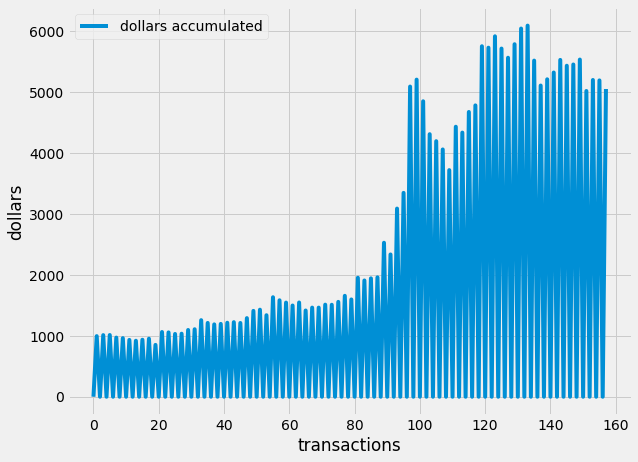

In [31]:
plt.figure(figsize=(9, 7))
plt.plot(cash_list, label='dollars accumulated')
plt.xlabel('transactions')
plt.ylabel('dollars')
plt.legend()
plt.show()

**With the all or nothing strategy we have here, we end up with \$5054.67.**
- Although we peaked at over \$6000 at one point.

**What would your net worth be if you had bought ethereum on the first day and sold only on the last day?**

In [32]:
price_day_first = X_test2.iloc[0]['eth_etherprice']
price_day_last = X_test2.iloc[404]['eth_etherprice']

items = 0
cash = 1000
items = items + (cash / price_day_first)
cash = 0
cash = cash + (items * price_day_last)
items = 0
print('Net etherium coins:', items)
print('Net dollars:', cash)

Net etherium coins: 0
Net dollars: 21942.8571429


- If we were to buy etherium on the first day, and then sell on the last day, we would have ended up with **\$21942.86.** This probably reflects on our earlier poor predictive KNN model's results, as we have now avoided many transactions that would have resulted in lots of accumulated losses.


- We lose most of our beginning money within the first 1/3rd of our trading, when the price is really low, *and the losses are just as numerous.*

### Try a new trading strategy. Does it work better?
- Algorithm 2:
- Only sell if the price is greater than the start price by a threshold.
- The threshold will be found by running an experiment.
- The range of the threshold for our experiment will be from 0 to 292:

In [33]:
list_ending_cash = []
for threshold in range(292):
    items = 0       # etherium coins
    cash = 1000     # our starting dollars
    cash_list = []  # to use for plotting

    for index, obs in X_test2.iterrows():
        price = obs['eth_etherprice']
        if obs['price_increase'] > 0:
            # buy all you can
            if cash > 0:
                items = items + (cash / price)
                cash = 0
        else: 
            # only sell if the price > threshold
            if items > 0 and price >= threshold:
                # sell it all
                cash = cash + (items * price)
                items = 0
    list_ending_cash.append(cash)

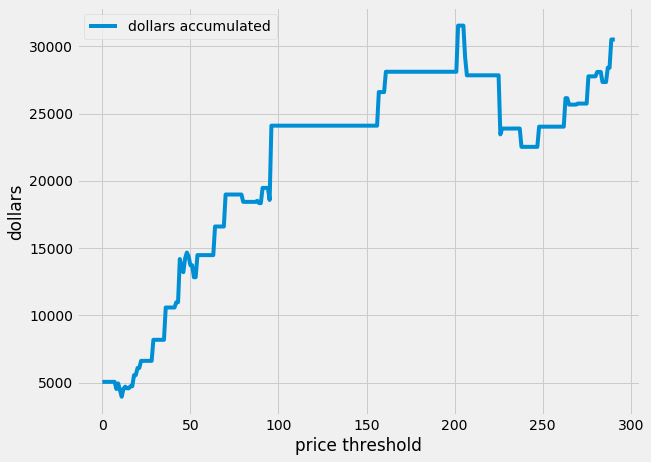

In [34]:
plt.figure(figsize=(9, 7))
plt.plot(list_ending_cash, label='dollars accumulated')
plt.xlabel('price threshold')
plt.ylabel('dollars')
plt.legend()
plt.show()

In [35]:
print(max(list_ending_cash))
print(list_ending_cash.index(max(list_ending_cash)))

31541.0195877
202


After running our experiment to find the best value for the threshold, we found that the threshold should be 202. The algorithm with the added condition, to only sell if the price > threshold, gives us a final dollar accumulation of **\$31541.02 with algorithm 2.** The result is quite a bit better than the previous result of buying on day 1 and selling on the last day, which gave us **\$21942.86.**

We are still held back a bit with the relatively poor predictive value of our K-NN model, with its poor f1-score. If we can increase the hit-rate with our predicted y column, this dollar value will definitely increase.

### Algorithm 2:

In [36]:
items = 0       # etherium coins
cash = 1000     # our starting dollars
cash_list = []  # to use for plotting
threshold = 202

for index, obs in X_test2.iterrows():
    price = obs['eth_etherprice']
    if obs['price_increase'] > 0:
        # buy all you can
        if cash > 0:
            items = items + (cash / price)
            cash = 0
            cash_list.append(cash)
    else: 
        # only sell if the price is more than our threshold
        if items > 0 and price >= threshold:
            # sell it all
            cash = cash + (items * price)
            items = 0
            cash_list.append(cash)

print('Net etherium coins:', items)
print('Net dollars:', cash)

Net etherium coins: 0
Net dollars: 31541.0195877


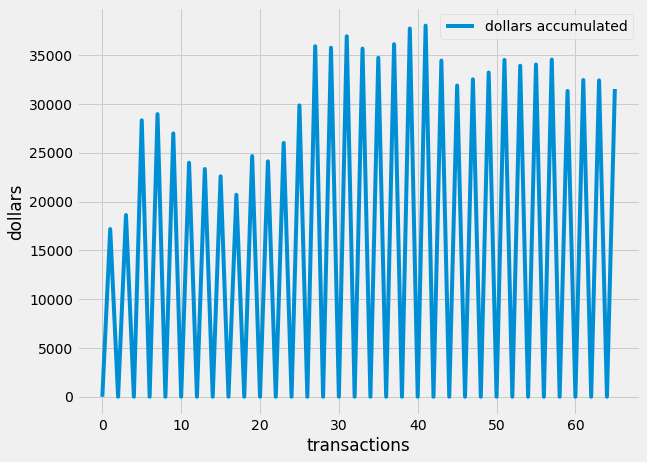

In [37]:
plt.figure(figsize=(9, 7))
plt.plot(cash_list, label='dollars accumulated')
plt.xlabel('transactions')
plt.ylabel('dollars')
plt.legend()
plt.show()

## Results and Findings:

Using two machine learning methods to produce a price increase prediction, k-Nearest Neighbors and Logistic Regression, we have arrived at our best predictive result with the k-NN model (k = 45). However, the results with the k-NN model are not much better than flipping a coin. The confusion matrix for our k-NN model is:
```
[[135  71]
 [121  78]]
```
Showing a relatively high number of false negatives (121). The **f1-score** for our KNN run is: **0.44828.**

```
             precision    recall  f1-score   support

          0       0.53      0.66      0.58       206
          1       0.52      0.39      0.45       199

avg / total       0.53      0.53      0.52       405
```
### Net worth exercises:

- With the original **all-or-nothing** algorithm, we ended up with a final net worth of **\$5054.67.**
- When we had **bought ethereum on the first day and sold only on the last day**, we ended up with **\$21942.86.**
- *With modified algorithm 2, when a **threshold is used for our selling** action, we end up with **\$31541.02.***

We have seen that our initial \$1000 is lost quickly when spending early, as we have many opportunities to lose it when the price of etherium is still low, but the losses are still happening at a relatively high rate due to our poor predictive power. By holding out until we have a large price increase, we are able to use the initial \$1000 to a greater advantage. This becomes more clear when examining the first 1/3rd of the scatterplot of the etherium price below, (where all of our false negatives cause us to sell too much).

By holding out during the earlier, low-return portion of the set of transactions, we were able to make more money with the same initial \$1000, ending up with **\$31541.02.**

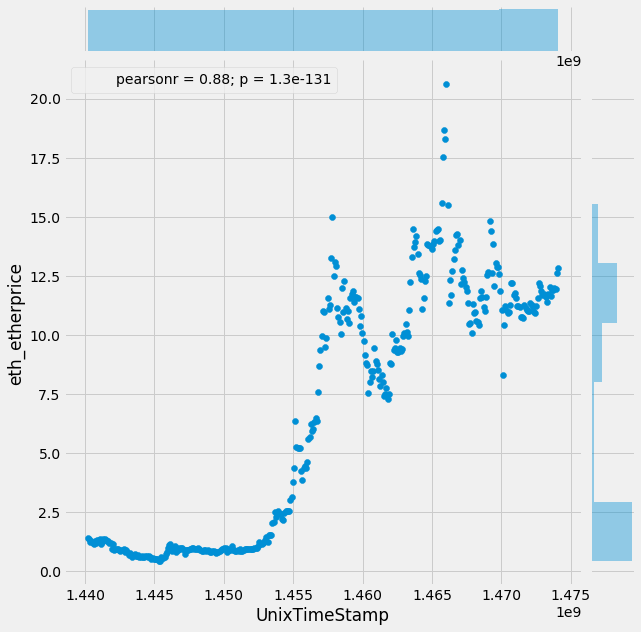

In [38]:
sns.jointplot('UnixTimeStamp', 'eth_etherprice', data=X_train, kind='scatter', size=9, ratio=10);